# Water Model Calibration

## TODO
- [x] Generate average model
- [ ] Network statistics of pipe locations and sensor locations

# Set Up

In [1]:
import wntr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy as sp
import chaospy as cp
from ipypb import track
from matplotlib import cm
import pickle
import datetime as dt

# Helper Methods

In [2]:
def savePickle(dataDict,picklePath):
    dataDict["timestamp"] = dt.datetime.now()
    pickle.dump( dataDict, open( picklePath, "wb" ) )

In [3]:
def loadPickle(picklePath):
    dataDict = pickle.load( open( picklePath, "rb" ) )
    return dataDict

In [4]:
def extractDataFrame(wn,objType="Pipe"):
    objsDict = {}
    try:
        objIter = wn.pipes()
        if objType == "Junction":
            objIter = wn.junctions()
        elif objType == "Tank":
            objIter = wn.tanks()
        elif objType == "Reservoir":
            objIter = wn.reservoirs()
        for obj in objIter:
            obj = obj[1]
            objDict = obj.todict()
            for k,v in objDict.items():
                if k in objsDict.keys():
                    objsDict[k].append(v)
                else:
                    objsDict[k] = [v]
        objsDF = pd.DataFrame(objsDict)
        return objsDF
    except:
        return objsDict

In [5]:
class ResultHelper():
    def __init__(self,results,convertResultsToHours=True):
        self.results = results
        
        # programatically set nodes
        for nodeKey in results.node.keys():
            self.__dict__[nodeKey] = results.node[nodeKey].T
        
        # progrmatically set links
        for linkKey in results.link.keys():
            self.__dict__[linkKey] = results.link[linkKey].T
        
        if convertResultsToHours:
            self.convertResultsToHours()
            
    def help(self):
        return list(self.__dict__.keys())
        
    def convertResultsToHours(self):
        for prop,value in self.__dict__.items():
            if type(value) == pd.DataFrame:
                value.columns = [float(seconds)/3600.0 for seconds in value.columns]
                
    def returnResult(self,resultType,resultLocationID,time):
        if resultType in self.__dict__.keys():
            resultDF = self.__dict__[resultType]
            if resultLocationID in resultDF.index:
                if time in resultDF.columns:
                    return self.__dict__[resultType].loc[resultLocationID][time]
                else:
                    print(f"{time} is not a valid time")
            else:
                print(f"{resultLocationID} is not a valid element in the network")
        else:
            print(f"{resultType} is not a valid property for ResultAnalyzer")
            return None

In [6]:
class Sensor():
    def __init__(self,sensorType,name,sensorSTD,dictOfPropertyValues):
        self.sensorType = sensorType
        self.name = name
        self.sensorSTD = sensorSTD
        self.dictOfPropertyValues = dictOfPropertyValues
        self.dictOfPropertyModelEstimates = {k:[] for k in dictOfPropertyValues.keys()}
        
    def calculateProbability(self,resultHelper):
        p = 1.0
        for sensorObservationTime,sensorObservationValue in self.dictOfPropertyValues.items():
            modelResult = resultHelper.returnResult(self.sensorType,self.name,sensorObservationTime)
            self.dictOfPropertyModelEstimates[sensorObservationTime].append(modelResult)
            distribution = stats.norm(sensorObservationValue,self.sensorSTD)
            p *= distribution.pdf(modelResult)
        return p
    
    def calculateProbability_Summed(self,resultHelper):
        p = 0.0
        for sensorObservationTime,sensorObservationValue in self.dictOfPropertyValues.items():
            modelResult = resultHelper.returnResult(self.sensorType,self.name,sensorObservationTime)
            self.dictOfPropertyModelEstimates[sensorObservationTime].append(modelResult)
            distribution = stats.norm(modelResult,self.sensorSTD)
            p += distribution.pdf(sensorObservationValue)
        return p        
    
    def calculateProbability_Summed_Log(self,resultHelper):
        p = 0.0
        for sensorObservationTime,sensorObservationValue in self.dictOfPropertyValues.items():
            modelResult = resultHelper.returnResult(self.sensorType,self.name,sensorObservationTime)
            self.dictOfPropertyModelEstimates[sensorObservationTime].append(modelResult)
            distribution = stats.norm(modelResult,self.sensorSTD)
            p += np.log(distribution.pdf(sensorObservationValue))
        return p       

In [7]:
class WaterNetworkHelper():
    def __init__(self,wn,name="Water Network"):
        self.wn = wn
        self.updatePipes()
        self.name = name
        
    def updatePipes(self):
        self.pipes = extractDataFrame(self.wn).set_index("name")
        self.nodes = extractDataFrame(self.wn,"Junction").set_index("name")
        self.tanks = extractDataFrame(self.wn,"Tank").set_index("name")
        self.reservoirs = extractDataFrame(self.wn,"Reservoir").set_index("name")
        
    def setPipeDiameter(self,pipeID,newDiameter):
        pipe = self.wn.get_link(pipeID)
        pipe.diameter = newDiameter
        self.updatePipes()
    
    def setPipeRoughness(self,pipeID,newRoughness):
        pipe = self.wn.get_link(pipeID)
        pipe.roughness = newRoughness
        self.updatePipes()
    
    def setPipeStatus(self,pipeID,newStatus):
        pipe = self.wn.get_link(pipeID)
        pipe.status = newStatus
        self.updatePipes()
            
    def runSimulation(self):
        sim = wntr.sim.EpanetSimulator(self.wn)
        results = ResultHelper(sim.run_sim())
        return results        
    
    def plotNetwork(self,figsize=(10,10),link_attribute=None,node_attribute=None):
        fig,ax = plt.subplots(figsize=figsize)
        wntr.graphics.plot_network(self.wn, title=self.name,ax=ax,node_attribute=node_attribute,link_attribute=link_attribute)

In [27]:
class Calibrator():
    def __init__(self,elementName,elementProperty,distribution,trueValue=None):
        self.elementName = elementName
        self.elementProperty = elementProperty
        self.prior = distribution # type of distribution
        self.values = []
        self.proposedValues = []
        self.trueValue = trueValue
        
    def generateProposal(self):
        return self.prior.rvs()
    
    def generateTransition(self,currentValue=None,σ=None):
        if not currentValue:
            currentValue = self.values[-1]
        if not σ:
            σ = self.prior.std()
        # simple gaussian case
        dist = stats.norm(currentValue,σ)
        return dist.rvs()
    
    def calculateProbability(self,value):
        return self.prior.pdf(value)
    
    def calculateProbability_Transition(self,value):
        dist = stats.norm(self.values[-1],self.prior.std())
        return dist.pdf(value)
    
    def fitDistribution(self,dist=stats.norm):
        params = dist.fit(calibrator.values)
        return params
        
    def setValue(self,waterNetworkHelper,newValue):
        if self.elementProperty == "diameter":
            waterNetworkHelper.setPipeDiameter(self.elementName,newValue)
        elif self.elementProperty == "roughness":
            waterNetworkHelper.setPipeRoughness(self.elementName,newValue)
        elif self.elementProperty == "status":
            waterNetworkHelper.setPipeStatus(self.elementName,newValue)
            
    def setValueToResult(self,waterNetworkHelper,resultMetric="mean",burnin=0.0):
        resultWithBurnin = self.values[int(burnin*len(self.values)):]
        result = np.mean(resultWithBurnin)
        if resultMetric == "median":
            result = np.median(resultWithBurnin)
        
        self.setValue(waterNetworkHelper,result)
            
    def plot(self,trueValue,burnin=0.0,ax=None):
        columnName = f"{self.elementName} {self.elementProperty}"
        valuesSubset = self.values[int(burnin*len(self.values)):len(self.values)+1]
        calibratorDFToPlot = pd.DataFrame({columnName:valuesSubset})
        if not ax:
            fig,ax = plt.subplots(figsize=(10,10))
        calibratorDFToPlot.plot(kind="hist",ax=ax,legend=False,density=True)
        ax.axvline(trueValue,color="red",ls="--",label="True Value")
        ax.set_title(f'{columnName}\nCalibrated Mean: {calibratorDFToPlot[columnName].mean():.1f}, Calibrated Median: {calibratorDFToPlot[columnName].median():.1f}\nTrue Value: {trueValue:.1f}\nPrior Mean: {self.prior.mean():.1f}')
        ax.set_xlabel(self.elementProperty)
        
        # add the prior distribution
        priorEstimates = []
        
        lspace = np.linspace(0,220,10000)
        ns = self.prior.pdf(lspace)
        sns.lineplot(lspace,ns,ax=ax,color="orange",alpha=0.2,label="Prior")
        ax.fill_between(lspace,ns, color="orange", alpha=0.1)
        
#         for i in range(0,10000):
#             priorEstimates.append(self.generateProposal())
#         priorEstimatesDF = pd.DataFrame({"Prior":priorEstimates})
#         priorEstimatesDF.plot(kind="hist",ax=ax,color="orange",alpha=0.1,label="Prior",density=True)
        return ax

    def plotRollingAverage(self,trueValue,burnin=0.0,ax=None,pointAlpha=0.1):
        if not ax:
            fig,ax = plt.subplots(figsize=(10,5))
            
        rollingAverages = []
        for i in range(1,len(self.values)):
            rollingAverages.append(np.mean(self.values[0:i]))
        sns.lineplot(range(1,len(self.values)),rollingAverages,ax=ax)
        ax.set_title(f"{self.elementName} {self.elementProperty} Rolling Average")
        ax.set_xlabel("Iteration")
        ax.set_ylabel(self.elementProperty)
        ax.axhline(trueValue,ls="--",alpha=0.1,color="red")
        sns.scatterplot(range(0,len(self.proposedValues)),self.proposedValues,marker="x",color="grey",alpha=pointAlpha,ax=ax)
        return ax
    
    def plotRollingSTD(self,trueValue,burnin=0.0,ax=None):
            if not ax:
                fig,ax = plt.subplots(figsize=(10,5))

            rollingStds = []
            for i in range(1,len(self.values)):
                rollingStds.append(np.std(self.values[0:i]))
            sns.lineplot(range(1,len(self.values)),rollingStds,ax=ax)
            ax.set_title(f"{self.elementName} {self.elementProperty} Rolling Standard Deviation")
            ax.set_xlabel("Iteration")
            ax.set_ylabel(self.elementProperty)
            return ax

# Methods for Markov Chain Monte Carlo

In [9]:
def π_Transition(listOfCalibrators):
    estimatesDict = {}
    for calibrator in listOfCalibrators:
        rv = calibrator.generateTransition()
        estimatesDict[calibrator] = rv
    return estimatesDict             

In [10]:
"""
This function generates the random numbers for the parameters being tested
"""
def π(listOfCalibrators):
    estimatesDict = {}
    for calibrator in listOfCalibrators:
        rv = calibrator.generateProposal()
        estimatesDict[calibrator] = rv
    return estimatesDict     

In [11]:
"""
This function calculates the probability that the parameters are 
pulled from their distribution
"""
def π_Prior(estimatesDict):
    p = 1.0
    for calibrator,parameterValue in estimatesDict.items():
#         pi = calibrator.calculateProbability(parameterValue)
        pi = calibrator.calculateProbability_Transition(parameterValue)
        p *= pi
    return p

In [12]:
"""
This function loops through a set of observations and calculates the
log-liklihood of each, summed
"""
def π_Log_Liklihood(listOfSensors,modelResult):
    logLiklihood = 0.0
    for sensor in listOfSensors:
        logLiklihood += sensor.calculateProbability_Summed_Log(modelResult)
#         logLiklihood += sensor.calculateProbability_Summed(modelResult)
#     logLiklihood = np.log(logLiklihood)
    return logLiklihood

In [13]:
def setParameterValues(proposedParameters):
    for calibrator,proposedParameterValue in proposedParameters.items():
        calibrator.values.append(proposedParameterValue)

In [14]:
def generateRandomCalibrators(waterNetwork,pAddCalibrator=0.05,calibrationParameter="roughness"):
    listOfCalibrators = []
    pAddCalibrator = 0.05
    for i,row in waterNetwork.pipes.iterrows():
        rand = np.random.random()
        if rand < pAddCalibrator:
            actualRoughness = row["roughness"]
            dist = stats.norm(actualRoughness,calibratorSTD)
            calibrator = Calibrator(i,"roughness",dist,trueValue=actualRoughness)
            listOfCalibrators.append(calibrator)
    return listOfCalibrators

In [15]:
def generateRandomSensors(waterNetwork,pAddSensor=0.2,sensorProperty="flowrate",timesToAdd=[1.00,2.25,5.00],sensorSTD=0.001):
    listOfSensors = []
    testResult = waterNetwork.runSimulation()
    for i,row in testResult.flowrate.iterrows():
        rand = np.random.random()
        if rand < pAddSensor:
            sensorProperty = "flowrate"
            sensorName = i
            sensorDict = {}
            for time in testResult.pressure.columns:
                if time in timesToAdd:
                    sensorDict[time] = row[time]
            sensor = Sensor(sensorProperty,sensorName,sensorSTD,sensorDict)
            listOfSensors.append(sensor)
    return listOfSensors

In [16]:
def generateListOfCalibrators(waterNetwork,listOfCalibratorLocations,calibrationParameter="roughness",calibratorSTD=30):
    listOfCalibrators = []
    for i,row in waterNetwork.pipes.iterrows():
        if i in listOfCalibratorLocations:
            actualRoughness = row["roughness"]
            dist = stats.norm(actualRoughness,calibratorSTD)
            calibrator = Calibrator(i,"roughness",dist,trueValue=actualRoughness)
            listOfCalibrators.append(calibrator)
    return listOfCalibrators

In [17]:
def generateListOfSensors(waterNetwork,listOfSensorLocations,sensorProperty="flowrate",timesToAdd=[1.00,2.25,5.00],sensorSTD=0.001):
    listOfSensors = []
    testResult = waterNetwork.runSimulation()
    for i,row in testResult.flowrate.iterrows():
        if i in listOfSensorLocations:
            sensorProperty = "flowrate"
            sensorName = i
            sensorDict = {}
            for time in testResult.pressure.columns:
                if time in timesToAdd:
                    sensorDict[time] = row[time]
            sensor = Sensor(sensorProperty,sensorName,sensorSTD,sensorDict)
            listOfSensors.append(sensor)
    return listOfSensors

In [18]:
def MCMC(waterNetwork,calibrators,sensors,nIterations=1000):
    dataDict = {}
    iterations = []
    acceptanceRatios = []
    isAccepted = []
    
    currentParameters = π(listOfCalibrators)
    for calibrator,proposedParameterValue in currentParameters.items():
        calibrator.values.append(proposedParameterValue)
        calibrator.setValue(waterNetwork,proposedParameterValue)
    currentModelResult = waterNetwork.runSimulation()
    
    for i in track(range(0,nIterations)):
        iterations.append(i)

        # generate a set of proposed values as a starting point
        proposedParameters = π_Transition(listOfCalibrators)
        for calibrator,proposedParameterValue in proposedParameters.items():
            calibrator.proposedValues.append(proposedParameterValue)
            # udpate the model
            calibrator.setValue(waterNetwork,proposedParameterValue)

        # run the model
        try:
            modelResult = waterNetwork.runSimulation()

            # calculate the acceptance probabilities
            α_1 = 0 #np.log(π_Prior(proposedParameters))
            α_2 = π_Log_Liklihood(listOfSensors,modelResult)
            α_3 = 0 #np.log(π_Prior({calibrator:calibrator.values[-1] for calibrator in listOfCalibrators}))
            α_4 = π_Log_Liklihood(listOfSensors,currentModelResult)
            α = np.exp(α_1 + α_2 - α_3 - α_4)
            α = min(1.0,α)
            acceptanceRatios.append(α)
            accepted = False

            # decide if we accept
            if α == 1: # accept
                setParameterValues(proposedParameters)
                currentParameters = proposedParameters
                currentModelResult = modelResult
                accepted = True
            else: # draw a random number and take the probability based on α
                rand = np.random.random()
                if rand < α: # accept
                    setParameterValues(proposedParameters)
                    currentParameters = proposedParameters
                    currentModelResult = modelResult
                    accepted = True
                else:
                    setParameterValues(currentParameters)

            # update our iteration
            # update parameter histories
            isAccepted.append(accepted)
        except:
            # model failed
            pass

    dataDict["iterations"] = iterations
    dataDict["acceptanceRatios"] = acceptanceRatios
    dataDict["isAccepted"] = isAccepted
    dataDict["calibrators"] = listOfCalibrators
    dataDict["sensors"] = listOfSensors
    dataDict["model"] = waterNetwork
    return dataDict

In [19]:
def GA():
    return None

# MCMC Step By Step

(<matplotlib.collections.PathCollection at 0x279763ec148>,
 <matplotlib.collections.LineCollection at 0x279763ec9c8>)

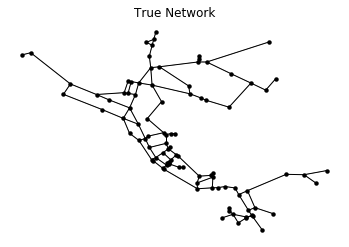

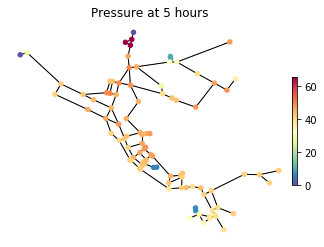

In [20]:
# Set up the known network
inp_file = 'networks/Net3.inp'
wn_true = wntr.network.WaterNetworkModel(inp_file)
waterNetwork = WaterNetworkHelper(wn_true)

# Graph the network
wntr.graphics.plot_network(wn_true, title="True Network")

# Simulate hydraulics
sim_true = wntr.sim.EpanetSimulator(wn_true)
results_true = sim_true.run_sim()

# Plot results on the network
pressure_at_5hr = results_true.node['pressure'].loc[5*3600, :]
wntr.graphics.plot_network(wn_true, node_attribute=pressure_at_5hr, node_size=30, 
                        title='Pressure at 5 hours')

In [28]:
listOfCalibrators = generateListOfCalibrators(waterNetwork,["204","225","229","173"],calibrationParameter="roughness",calibratorSTD=30)
listOfSensors = generateRandomSensors(waterNetwork)
resultsDict = MCMC(waterNetwork,listOfCalibrators,listOfSensors,nIterations=100)

 [████████████████████████████████████████████████████████████] 100/100 [00:44<00:00, 0.44s/it]

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning:

divide by zero encountered in log



# Functions to Plot Results

In [29]:
def generateResultingModel(waterNetwork,listOfCalibrators,burnin=0.25,resultMetric="mean"):
    for calibrator in listOfCalibrators:
        calibrator.setValueToResult(waterNetwork,burnin=burnin,resultMetric=resultMetric)
    results = waterNetwork.runSimulation()
    return results

In [34]:
calibratedModel = generateResultingModel(waterNetwork,listOfCalibrators)

In [35]:
resultsDict.keys()

dict_keys(['iterations', 'acceptanceRatios', 'isAccepted', 'calibrators', 'sensors', 'model'])

In [39]:
def plotDifferencesInResults(resultsDict,time=5.00,burnin=0.2,resultMetric="mean"):
    # set up the actual model
    listOfCalibrators = resultsDict["calibrators"]
    isAccepted = resultsDict["isAccepted"]
    
    waterNetwork = resultsDict["model"]
    for calibrator in listOfCalibrators:
        calibrator.setValue(waterNetwork,calibrator.trueValue)
    actualModelResults = waterNetwork.runSimulation()
    
    # set up the calibrated mdoel
    for calibrator in listOfCalibrators:
        calibrator.setValueToResult(waterNetwork,burnin=burnin,resultMetric=resultMetric)
    calibratedModelResults = waterNetwork.runSimulation()
    
    # plot the results
    fig,ax = plt.subplots(figsize=(20,5))
    (actualModelResults.flowrate[time] - calibratedModelResults.flowrate[time]).plot(ax=ax,kind="bar")
    ax.set_title(f"Actual Differences in Link Flow Rates at Hour {time}\nAcceptance Rate: {np.sum(isAccepted)/len(isAccepted)} of {len(isAccepted)} Iterations");

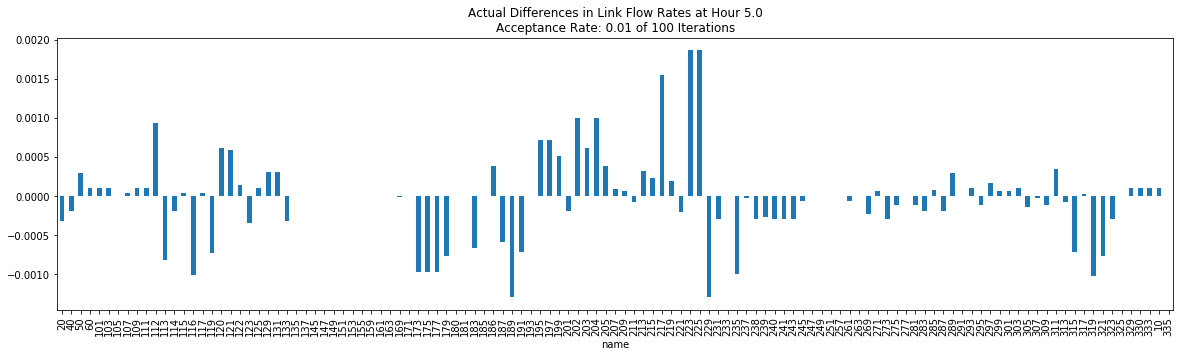

In [40]:
plotDifferencesInResults(resultsDict)

In [41]:
def plotCalibratorResults(listOfCalibrators,burnin=0.2,figsize=(22,7),savePath=None,pointAlpha=0.2):
    for calibrator in listOfCalibrators:
        fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=figsize)
        calibrator.plot(calibrator.trueValue,burnin=burnin,ax=ax1)
        calibrator.plotRollingAverage(calibrator.trueValue,burnin=burnin,ax=ax2,pointAlpha=pointAlpha)
        calibrator.plotRollingSTD(calibrator.trueValue,burnin=burnin,ax=ax3)
    if savePath:
        fig.savefig(savePath)
    return (ax1,ax2,ax3)

(<matplotlib.axes._subplots.AxesSubplot at 0x2797a8a7a88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2797a910fc8>)

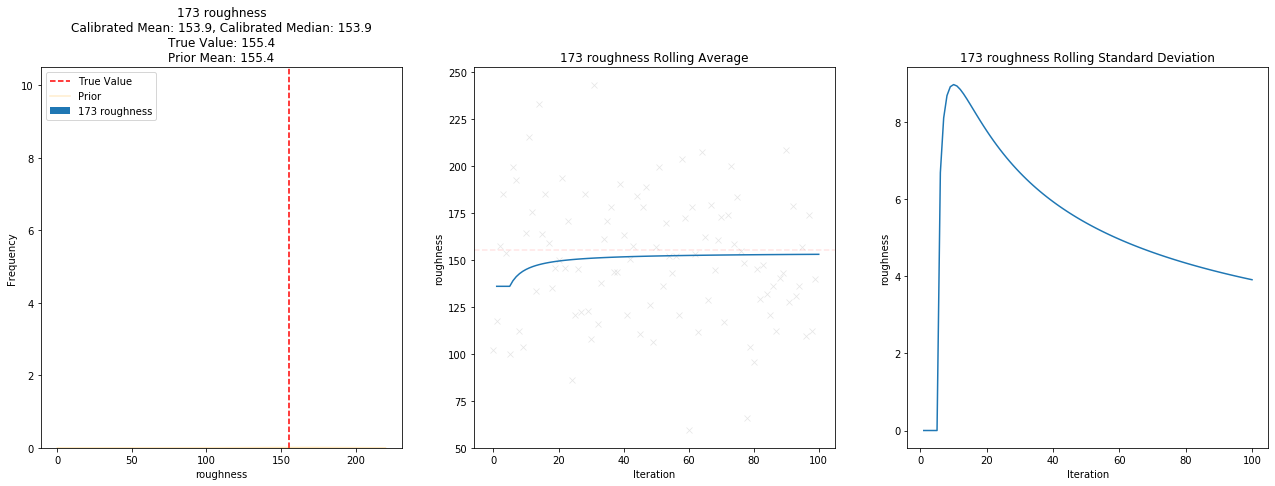

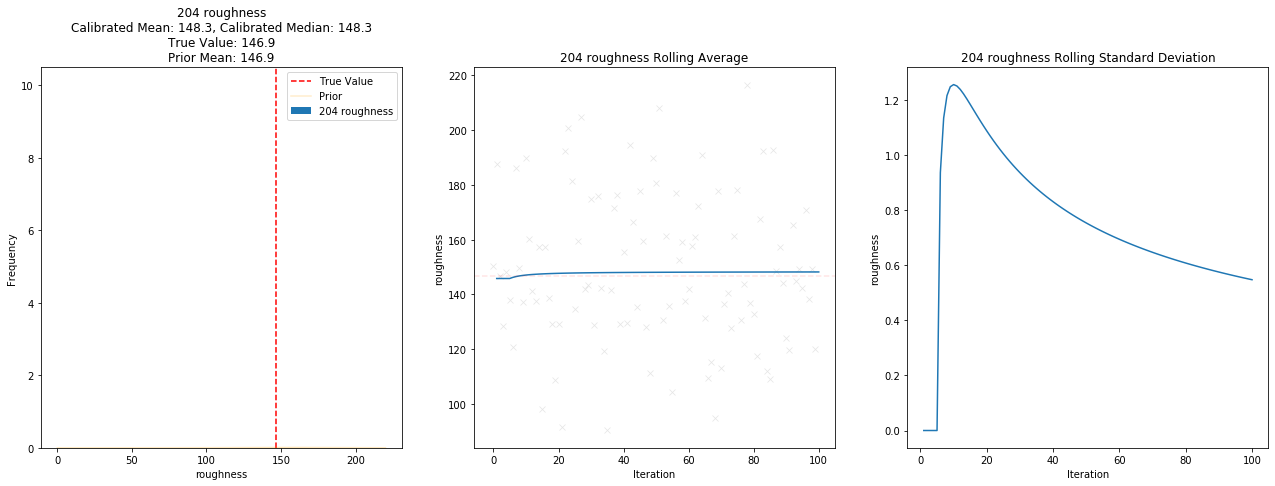

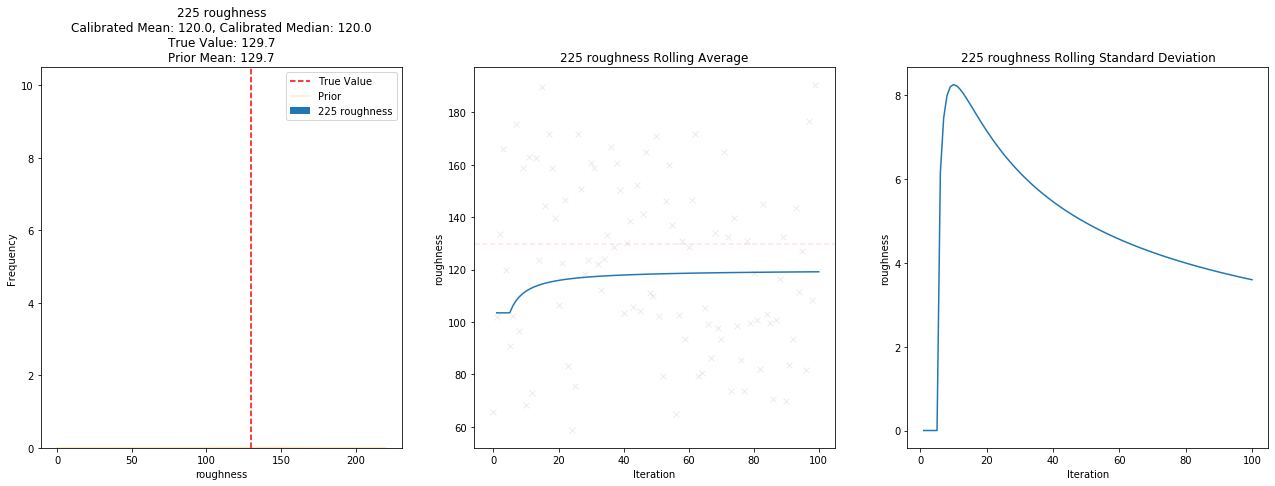

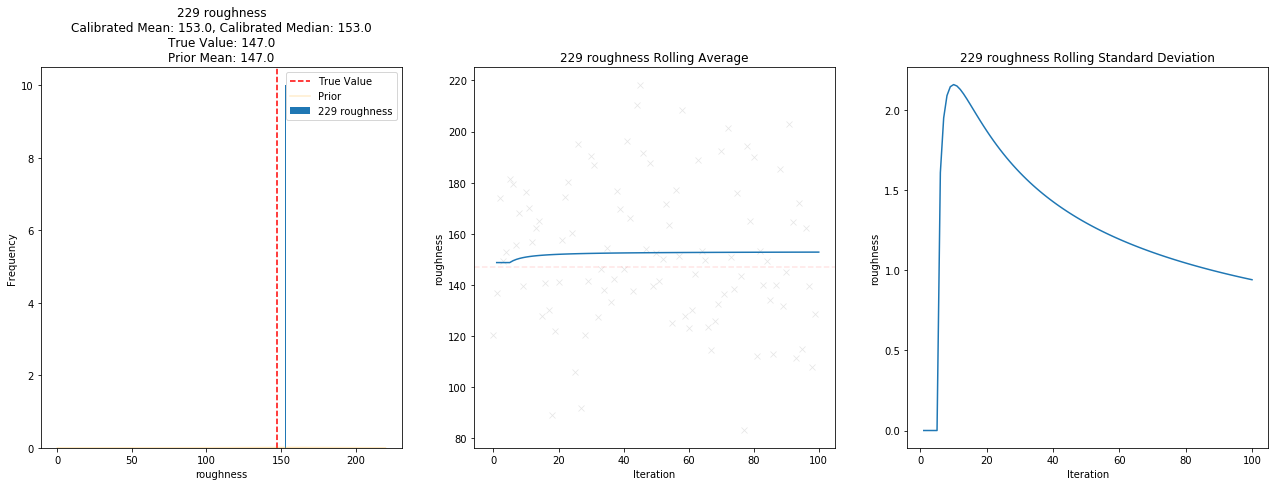

In [33]:
plotCalibratorResults(listOfCalibrators)

In [ ]:
fig,ax = plt.subplots(figsize=(20,5))
(testResult.flowrate[5.00] - resultingResult.flowrate[5.00]).plot(ax=ax,kind="bar")
ax.set_title(f"Actual Differences in Link Flow Rates at Hour 5\nAcceptance Rate: {np.sum(isAccepted)/len(isAccepted)}");

In [ ]:
res

In [ ]:
resultModel = wntr.network.WaterNetworkModel(inp_file)
resultNetwork = WaterNetworkHelper(wn_true)
for calibrator in listOfCalibrators:
    calibrator.setValueToResult(resultNetwork,burnin=0.25,resultMetric="mean")
resultingResult = waterNetwork.runSimulation()

In [ ]:
fig,ax = plt.subplots(figsize=(20,5))
(testResult.pressure[5.00] - currentModelResult.pressure[5.00]).plot(ax=ax,kind="bar")
ax.set_title(f"Actual Differences in Node Pressures\nAcceptance Rate: {np.sum(isAccepted)/len(isAccepted)}");

In [ ]:
fig,ax = plt.subplots(figsize=(20,5))
(testResult.flowrate[5.00] - currentModelResult.flowrate[5.00]).plot(ax=ax,kind="bar")
ax.set_title(f"Actual Differences in Link Flow Rates\nAcceptance Rate: {np.sum(isAccepted)/len(isAccepted)}");

In [ ]:
for calibrator in listOfCalibrators:
    print(np.std(calibrator.values))

In [ ]:
savePickle({"name":"10,000 iterations first try","listOfSensors":listOfSensors,"listOfCalibrators":listOfCalibrators},"trial1.pkl")

In [ ]:
testResults = loadPickle("trial1.pkl")

In [ ]:
testResults

In [ ]:
df_sensors.columns

In [ ]:
df_true.T.index

NameError: name 'n' is not defined

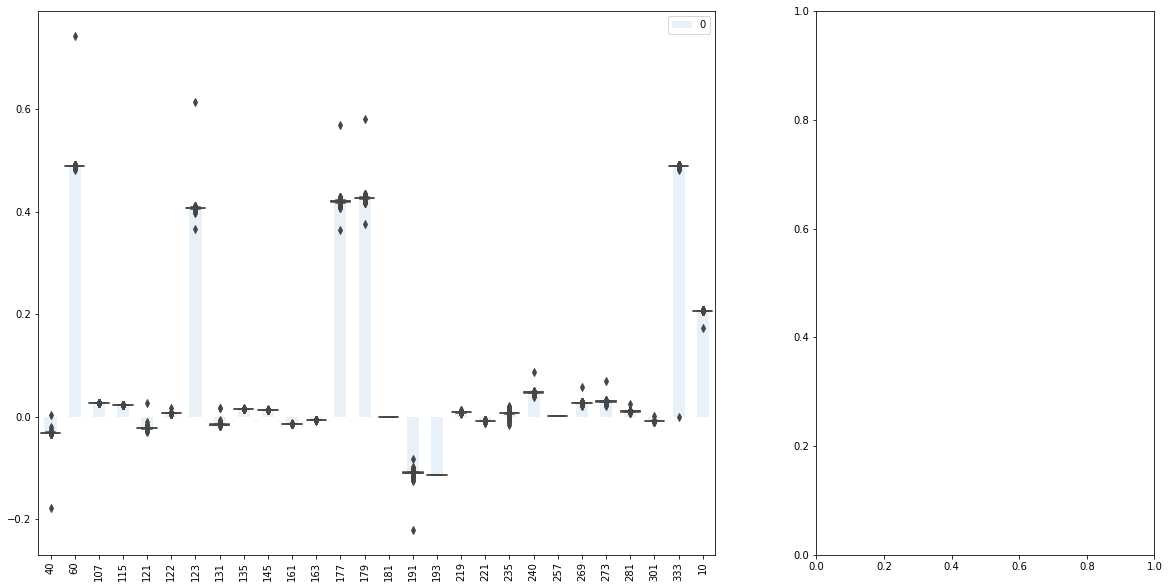

In [42]:
fig,(ax,mapAx) = plt.subplots(1,2,figsize=(20,10),gridspec_kw={'width_ratios':[2,1]})
dict_sensors = {}
dict_trueValues = {}
burnIn = 0.0
for sensor in listOfSensors:
    dict_sensors[sensor.name]=sensor.dictOfPropertyModelEstimates[5.00][int(burnIn*len(sensor.dictOfPropertyModelEstimates[5.00])):len(sensor.dictOfPropertyModelEstimates[5.00])+1]
    dict_trueValues[sensor.name] = [sensor.dictOfPropertyValues[5.00]]
df_sensors = pd.DataFrame(dict_sensors)
sns.boxplot(data=df_sensors,ax=ax)
# df_sensors.plot(kind="box",ax=ax)
df_true = pd.DataFrame(dict_trueValues)
df_true.T.plot(ax=ax,kind="bar",alpha=0.1)
ax.set_title(f"Sensor Ranges Compared to True Values\n{burnIn*100:.1f}% Burn In After {n} Iterations\nAcceptance Rate: {np.sum(isAccepted)/len(isAccepted)*100:.1f}%")


baseNetwork = wntr.network.WaterNetworkModel(inp_file)
calibratorNetwork = wntr.network.WaterNetworkModel(inp_file)
sensorNetwork = wntr.network.WaterNetworkModel(inp_file)

allPipes = [pipe[0] for pipe in baseNetwork.pipes()]

calibratorPipes = [calibrator.elementName for calibrator in listOfCalibrators]
sensorPipes = [sensor.name for sensor in listOfSensors]

for control in list(calibratorNetwork.controls()):
    try:
        calibratorNetwork.remove_control(control[0])
        sensorNetwork.remove_control(control[0])
    except:
        print(f"error removing {control[0]}")
        pass
    
for pipe in allPipes:
    if pipe not in calibratorPipes:
        try:
            calibratorNetwork.remove_link(pipe)
        except:
            print(f"could not remove {pipe} from calibrators")
    if pipe not in sensorPipes:
        try:
            sensorNetwork.remove_link(pipe)
        except:
            print(f"could not remove {pipe} from sensors")

wntr.graphics.plot_network(baseNetwork,link_alpha=0.1,node_alpha=0.1,ax=mapAx,link_labels=False)
wntr.graphics.plot_network(calibratorNetwork,ax=mapAx,node_alpha=0.0,link_labels=True,link_width=5,link_cmap=cm.autumn)
wntr.graphics.plot_network(sensorNetwork,ax=mapAx,node_alpha=0.0,link_labels=False,link_width=2)
mapAx.set_title("Sensor and Calibrator Arrangement\nThick Lines are Calibrators\nThinner Lines are Sensors\nGrey Lines are Fixed")

In [ ]:
fig,ax = plt.subplots()
pd.DataFrame({"Accepted Values":calibrator.values}).plot(kind="line",ax=ax,label="Accepted Values")
pd.DataFrame({"Proposed Values":calibrator.proposedValues}).plot(kind="line",ax=ax,color="grey",alpha=0.1,label="Proposed Values")
ax.axhline(trueValues[calibrator],ls="--",color="red",label="True Value")
ax.legend()
ax.set_title(f"{calibrator.elementName} {calibrator.elementProperty}");

In [ ]:
for calibrator in listOfCalibrators:
    burnin = 0.25
    fig,ax = plt.subplots()
    pd.DataFrame({"Accepted Values":calibrator.values}).plot(kind="line",ax=ax,label="Accepted Values")
    pd.DataFrame({"Proposed Values":calibrator.proposedValues}).plot(kind="line",ax=ax,color="grey",alpha=0.1,label="Proposed Values")
    ax.axhline(trueValues[calibrator],ls="--",color="red",label="True Value")
    ax.set_title(f"{calibrator.elementName} {calibrator.elementProperty}");
    ax.axvspan(0,int(burnin*len(calibrator.values)),alpha=0.05,color="red",label="Burn In Discard Range")
    ax.legend()

In [ ]:
len(calibrator.proposedValues)

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
rollingAverages = []
for i in range(1,len(calibrator.values)):
    rollingAverages.append(np.mean(calibrator.values[0:i]))
sns.lineplot(range(1,len(calibrator.values)),rollingAverages,ax=ax)
ax.set_title(f"{calibrator.elementName} {calibrator.elementProperty} Rolling Average")
ax.set_xlabel("Iteration")
ax.set_ylabel(calibrator.elementProperty)
ax.axhline(trueValues[calibrator],ls="--",alpha=0.5,color="red")
sns.scatterplot(range(0,len(calibrator.proposedValues)),calibrator.proposedValues,marker="x",color="grey",alpha=0.05)

In [ ]:
for calibrator in listOfCalibrators:
    fig,ax = plt.subplots(figsize=(10,5))
    rollingAverages = []
    for i in range(1,len(calibrator.values)):
        rollingAverages.append(np.mean(calibrator.values[0:i]))
    sns.lineplot(range(1,len(calibrator.values)),rollingAverages,ax=ax)
    ax.set_title(f"{calibrator.elementName} {calibrator.elementProperty} Rolling Average")
    ax.set_xlabel("Iteration")
    ax.set_ylabel(calibrator.elementProperty)
    ax.axhline(trueValues[calibrator],ls="--",alpha=0.5,color="red")
    sns.scatterplot(range(0,len(calibrator.proposedValues)),calibrator.proposedValues,marker="x",color="grey",alpha=0.05)

In [ ]:
plotNetworkSetup(resultsDict)

In [ ]:
def plotNetworkSetup(resultsDict,burnIn=0.25):
    iterations = resultsDict["iterations"]
    acceptanceRatios = resultsDict["acceptanceRatios"]
    isAccepted = resultsDict["isAccepted"]
    listOfCalibrators = resultsDict["calibrators"]
    listOfSensors = resultsDict["sensors"]
    waterNetwork = resultsDict["model"]
    
    fig,ax = plt.subplots(figsize=(20,10))
    dict_sensors = {}
    dict_trueValues = {}
    for sensor in listOfSensors:
        dict_sensors[sensor.name]=sensor.dictOfPropertyModelEstimates[5.00][int(burnIn*len(sensor.dictOfPropertyModelEstimates[5.00])):len(sensor.dictOfPropertyModelEstimates[5.00])+1]
        dict_trueValues[sensor.name] = [sensor.dictOfPropertyValues[5.00]]
    df_sensors = pd.DataFrame(dict_sensors)
    sns.boxplot(data=df_sensors,ax=ax)
    # df_sensors.plot(kind="box",ax=ax)
    df_true = pd.DataFrame(dict_trueValues)
    df_true.T.plot(ax=ax,kind="bar",alpha=0.1)
    n=100
    ax.set_title(f"Sensor Ranges Compared to True Values\n{burnIn*100:.1f}% Burn In After {n} Iterations\nAcceptance Rate: {np.sum(isAccepted)/len(isAccepted)*100:.1f}%")


    baseNetwork = wntr.network.WaterNetworkModel(inp_file)
    calibratorNetwork = wntr.network.WaterNetworkModel(inp_file)
    sensorNetwork = wntr.network.WaterNetworkModel(inp_file)

    allPipes = [pipe[0] for pipe in baseNetwork.pipes()]

    calibratorPipes = [calibrator.elementName for calibrator in listOfCalibrators]
    sensorPipes = [sensor.name for sensor in listOfSensors]

    for control in list(calibratorNetwork.controls()):
        try:
            calibratorNetwork.remove_control(control[0])
            sensorNetwork.remove_control(control[0])
        except:
            print(f"error removing {control[0]}")
            pass

    for pipe in allPipes:
        if pipe not in calibratorPipes:
            try:
                calibratorNetwork.remove_link(pipe)
            except:
                print(f"could not remove {pipe} from calibrators")
        if pipe not in sensorPipes:
            try:
                sensorNetwork.remove_link(pipe)
            except:
                print(f"could not remove {pipe} from sensors")

    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,10))
    wntr.graphics.plot_network(baseNetwork,link_alpha=1.0,node_alpha=0.1,ax=ax1,link_labels=True)
    wntr.graphics.plot_network(baseNetwork,link_alpha=0.05,node_alpha=0.1,ax=ax2,link_labels=False)
    wntr.graphics.plot_network(baseNetwork,link_alpha=0.05,node_alpha=0.1,ax=ax3,link_labels=False)
    wntr.graphics.plot_network(calibratorNetwork,ax=ax2,node_alpha=0.0,link_labels=True,link_width=5,link_cmap=cm.autumn)
    wntr.graphics.plot_network(sensorNetwork,ax=ax3,node_alpha=0.0,link_labels=True,link_width=2)
    fig.suptitle("Sensor and Calibrator Arrangement")
    ax1.set_title("Overall Network")
    ax2.set_title("Network Elements Being Calibrated")
    ax3.set_title("Sensor Locations")

In [ ]:
baseNetwork = wntr.network.WaterNetworkModel(inp_file)
calibratorNetwork = wntr.network.WaterNetworkModel(inp_file)
sensorNetwork = wntr.network.WaterNetworkModel(inp_file)

allPipes = [pipe[0] for pipe in baseNetwork.pipes()]

calibratorPipes = [calibrator.elementName for calibrator in listOfCalibrators]
sensorPipes = [sensor.name for sensor in listOfSensors]

for control in list(calibratorNetwork.controls()):
    try:
        calibratorNetwork.remove_control(control[0])
        sensorNetwork.remove_control(control[0])
    except:
        print(f"error removing {control[0]}")
        pass
    
for pipe in allPipes:
    if pipe not in calibratorPipes:
        try:
            calibratorNetwork.remove_link(pipe)
        except:
            print(f"could not remove {pipe} from calibrators")
    if pipe not in sensorPipes:
        try:
            sensorNetwork.remove_link(pipe)
        except:
            print(f"could not remove {pipe} from sensors")
            
fig,ax = plt.subplots(figsize=(10,10))
wntr.graphics.plot_network(baseNetwork,link_alpha=0.1,node_alpha=0.1,ax=ax,link_labels=True)
wntr.graphics.plot_network(calibratorNetwork,ax=ax,node_alpha=0.0,link_labels=True,link_width=5)
wntr.graphics.plot_network(sensorNetwork,ax=ax,node_alpha=0.0,link_labels=True,link_width=2)

# To Delete

In [ ]:
# Set up the known network
inp_file = 'networks/Net3.inp'
wn_true = wntr.network.WaterNetworkModel(inp_file)
waterNetwork = WaterNetworkHelper(wn_true)
testResult = waterNetwork.runSimulation()

In [ ]:
toCalibrate = ["204","225","229","173"]
listOfCalibrators = []
listOfSensors = []
calibratorPipes = []
trueValues = {}
pAddCalibrator = 0.05
for i,row in waterNetwork.pipes.iterrows():
    if i in toCalibrate:
        actualRoughness = row["roughness"]
        dist = stats.norm(actualRoughness,30)
        randomRoughness = dist.rvs()
        calibrator = Calibrator(i,"roughness",stats.norm(randomRoughness,15))
        trueValues[calibrator] = actualRoughness
        listOfCalibrators.append(calibrator)
        calibratorPipes.append(i)

toCalibrate = ["204","225","229"]
listOfCalibrators = []
listOfSensors = []
calibratorPipes = []
trueValues = {}
pAddCalibrator = 0.05
for i,row in waterNetwork.pipes.iterrows():
    rand = np.random.random()
    if rand < pAddCalibrator:
        actualRoughness = row["roughness"]
        dist = stats.norm(actualRoughness,15)
        randomRoughness = dist.rvs()
        calibrator = Calibrator(i,"roughness",stats.norm(randomRoughness,15))
        trueValues[calibrator] = actualRoughness
        listOfCalibrators.append(calibrator)
        calibratorPipes.append(i)

for sensorName,row in testResult.flowrate.iterrows():
    sensorProperty = "flowrate"
    sensorSTD = 0.001
    sensorDict = {}
    sensorDict[5.00] = row[5.00]
    sensor = Sensor(sensorProperty,sensorName,sensorSTD,sensorDict)
    if sensorName in calibratorPipes:
        listOfSensors.append(sensor)

trueValues = {calibrator1:199,calibrator2:199,calibrator3:140}

In [ ]:
listOfSensors = []
pAddSensor = 0.2
for i,row in testResult.flowrate.iterrows():
    sensorProperty = "flowrate"
    sensorName = i
    sensorSTD = 0.001
    sensorDict = {}
#     for time in testResult.pressure.columns:
#         sensorDict[time] = row[time]
    sensorDict[1.00] = row[1.00]
    sensorDict[2.25] = row[2.25]
    sensorDict[5.00] = row[5.00]
    sensor = Sensor(sensorProperty,sensorName,sensorSTD,sensorDict)
    rand = np.random.random()
    if rand < pAddSensor:
        listOfSensors.append(sensor)

sensor1 = Sensor("pressure","15",2,{0.0:28.593653,0.25:28.646692})
sensor2 = Sensor("pressure","40",1,{0.0:3.992880,0.25:4.042458})

listOfSensors = [sensor1,sensor2]

In [ ]:
iterations = []
acceptanceRatios = []
isAccepted = []

In [ ]:
currentParameters = π(listOfCalibrators)
for calibrator,proposedParameterValue in currentParameters.items():
    calibrator.values.append(proposedParameterValue)
    calibrator.setValue(waterNetwork,proposedParameterValue)
currentModelResult = waterNetwork.runSimulation()

In [ ]:
n = 10000

In [ ]:
for i in track(range(0,n)):
    iterations.append(i)
    
    # generate a set of proposed values as a starting point
    proposedParameters = π_Transition(listOfCalibrators)
    for calibrator,proposedParameterValue in proposedParameters.items():
        calibrator.proposedValues.append(proposedParameterValue)
        # udpate the model
        calibrator.setValue(waterNetwork,proposedParameterValue)
    
    # run the model
    try:
        modelResult = waterNetwork.runSimulation()

        # calculate the acceptance probabilities
        α_1 = 0 #np.log(π_Prior(proposedParameters))
        α_2 = π_Log_Liklihood(listOfSensors,modelResult)
        α_3 = 0 #np.log(π_Prior({calibrator:calibrator.values[-1] for calibrator in listOfCalibrators}))
        α_4 = π_Log_Liklihood(listOfSensors,currentModelResult)
        α = np.exp(α_1 + α_2 - α_3 - α_4)
        α = min(1.0,α)
        acceptanceRatios.append(α)
        accepted = False

        # decide if we accept
        if α == 1: # accept
            setParameterValues(proposedParameters)
            currentParameters = proposedParameters
            currentModelResult = modelResult
            accepted = True
        else: # draw a random number and take the probability based on α
            rand = np.random.random()
            if rand < α: # accept
                setParameterValues(proposedParameters)
                currentParameters = proposedParameters
                currentModelResult = modelResult
                accepted = True
            else:
                setParameterValues(currentParameters)

        # update our iteration
        # update parameter histories
        isAccepted.append(accepted)
    except:
        pass

# generate the return data frame


In [ ]:
for calibrator in listOfCalibrators:
    print(calibrator.fitDistribution())
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(22,7))
    calibrator.plot(trueValues[calibrator],burnin=0.50,ax=ax1)
    calibrator.plotRollingAverage(trueValues[calibrator],burnin=0.50,ax=ax2)
    calibrator.plotRollingSTD(trueValues[calibrator],burnin=0.50,ax=ax3)